In [1]:
%matplotlib notebook

from rlsm.datasets import load_consulting
from rlsm import ReciprocityLSM

In [2]:
Y = load_consulting()

In [3]:
model = ReciprocityLSM(n_features=2, reciprocity_type='distance', random_state=42)
model.sample(Y, n_warmup=2500, n_samples=5000)

sample: 100%|████████████████████████████████████████████████████████████████| 7500/7500 [01:06<00:00, 112.34it/s, 63 steps of size 5.15e-02. acc. prob=0.83]


In [4]:
model.print_summary()

AUC: 0.970, WAIC: 2396.036

                  mean       std    median      2.5%     97.5%     n_eff     r_hat
  recip_coef      0.49      0.36      0.49     -0.21      1.19   1794.43      1.00
   dist_coef      0.43      0.07      0.44      0.28      0.58   1938.74      1.00
       s_var      2.21      0.48      2.16      1.34      3.16    949.73      1.00
       r_var      0.71      0.18      0.69      0.39      1.07   1484.98      1.00
     sr_corr     -0.15      0.17     -0.15     -0.47      0.17    948.48      1.00

Number of divergences: 61


<IPython.core.display.Javascript object>


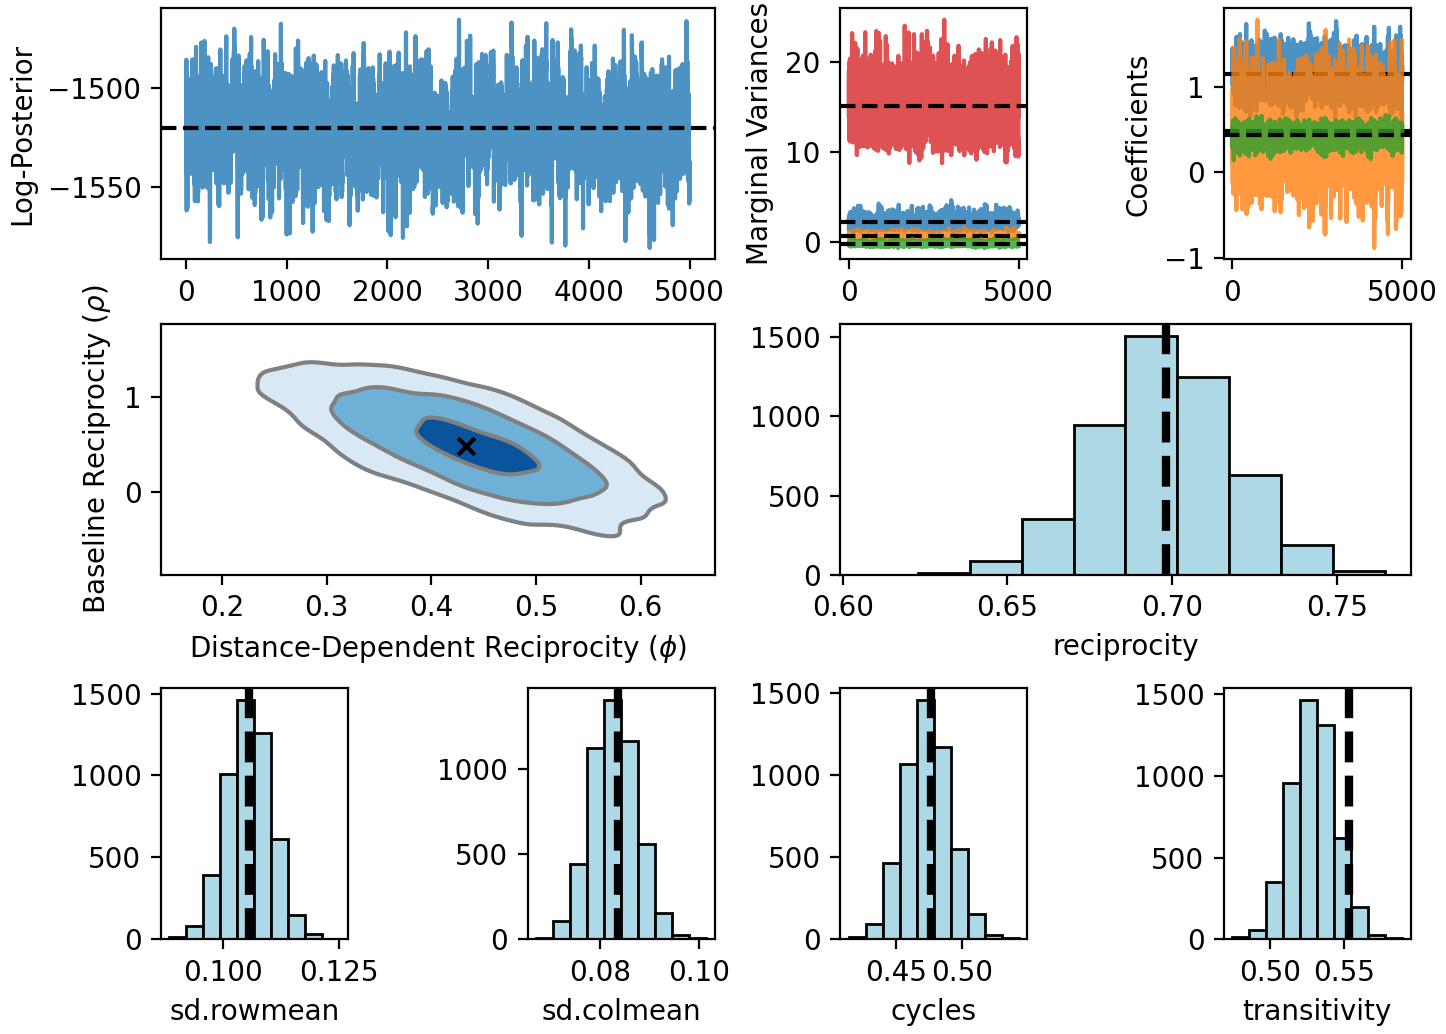

In [5]:
model.plot();

<IPython.core.display.Javascript object>


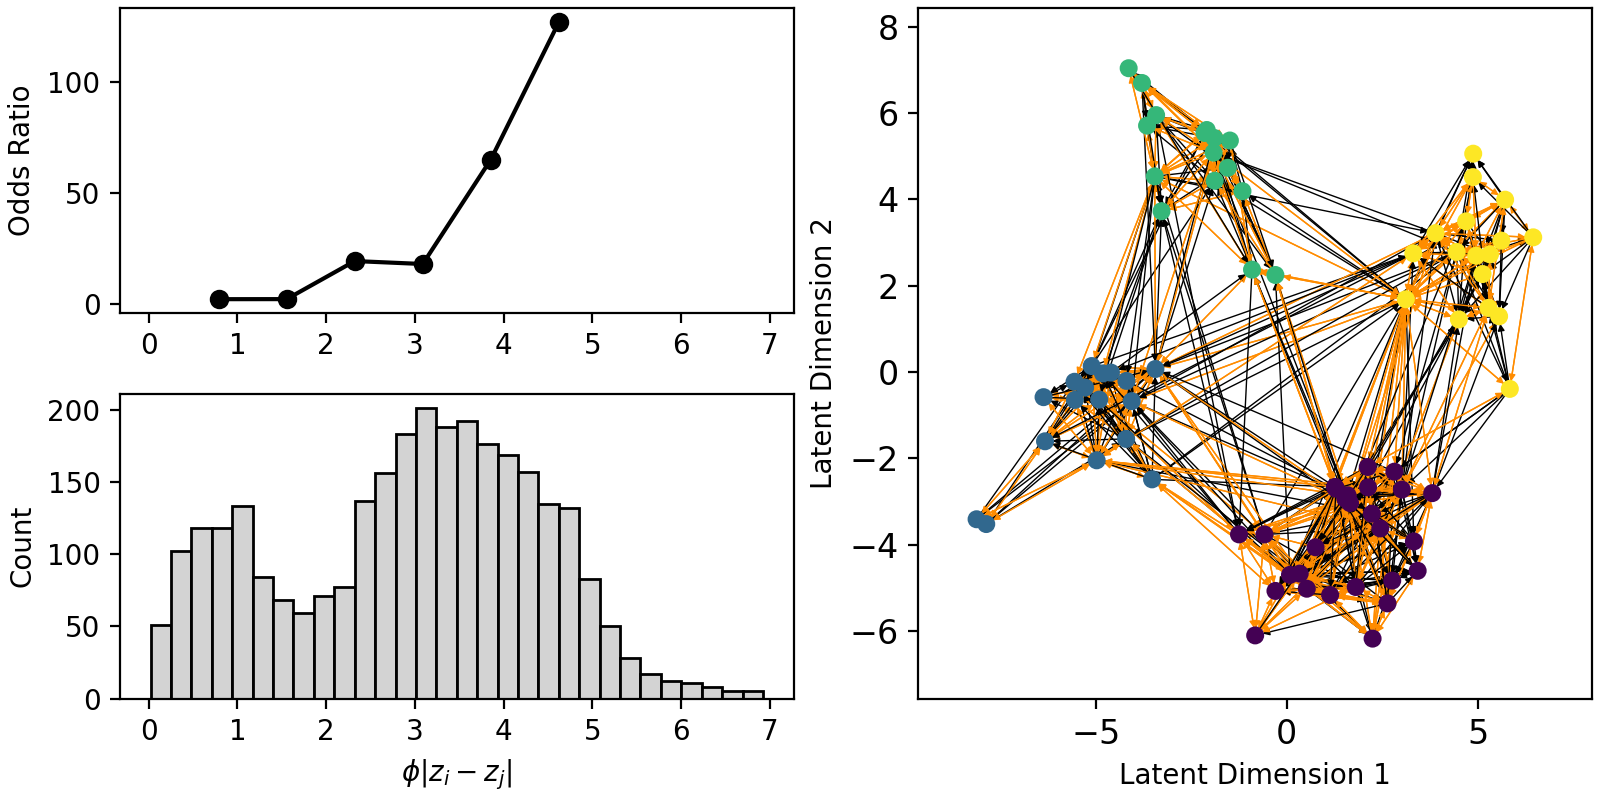

/var/folders/v3/2j2q_5r946l7qp1c47w5x7lc0000gn/T/ipykernel_34525/1198190639.py:13: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(pairwise_distance(model.Z_))


In [6]:
from rlsm.rlsm import pairwise_distance
from rlsm.network_utils import adjacency_to_dyads, dyads_to_multinomial
import networkx as nx
from sklearn.cluster import KMeans

ax = plt.figure(constrained_layout=True, figsize=(8,4)).subplot_mosaic(
    """
    AABB
    CCBB
    """
)

D = np.sqrt(pairwise_distance(model.Z_))
d = np.abs(model.samples_['dist_coef'].mean())  * adjacency_to_dyads(D, n=D.shape[0])[:, 0]
dyads = adjacency_to_dyads(Y, n=D.shape[0])

res = []
qs = np.linspace(d.min(), d.max(), 10)
#qs = np.quantile(d, q=np.linspace(0, 1, 10))
dist = []
for i in range(qs.shape[0]-1):
    a = dyads_to_multinomial(dyads[np.where(np.logical_and(d >= qs[i], d <= qs[i+1]))[0]])
    tots = a.sum(axis=0) 
    gamma = (tots[0] * tots[-1]) / (tots[1] * tots[2]) 
    if tots[1] * tots[2] > 0:
        res.append(gamma)
        dist.append(qs[i+1])

ax['C'].hist(d, bins=30, color='lightgray', edgecolor='k')#.histplot(d, axes=ax[0])
ax['A'].plot(np.asarray(dist), res, 'ko-')
#ax[0].axvline(model.recip_coef_, linestyle=':', color='gray', lw=2)
ax['A'].set_ylabel('Odds Ratio')
ax['C'].set_ylabel('Count')
ax['C'].set_xlabel(r'$\phi |z_i - z_j|$')

kmeans = KMeans(n_clusters=4).fit(model.Z_[:, :2])

g = nx.from_numpy_array(Y, create_using=nx.DiGraph)
pos = {k : model.Z_[k, :2] for k in range(Y.shape[0])}
elist = list(nx.to_edgelist(g))
ecolor = ['darkorange' if Y[e[1], e[0]] else 'k' for e in elist]
nx.draw_networkx(g, pos, 
                 node_color=kmeans.labels_,
                 edge_color=ecolor, width=0.5, with_labels=False,
                 arrowsize=5,
                 node_size=30, ax=ax['B'])
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)
ax['B'].set_ylabel('Latent Dimension 2')
ax['B'].set_xlabel('Latent Dimension 1')
ax['A'].sharex(ax['C'])

## No Reciprocity

In [ ]:
model_none = ReciprocityLSM(n_features=2, reciprocity_type='none', random_state=42)
model_none.sample(Y, n_warmup=2500, n_samples=5000)

warmup:  28%|█████████████████▌                                             | 2094/7500 [04:12<10:42,  8.41it/s, 1023 steps of size 2.65e-04. acc. prob=0.79]

In [9]:
model_none.print_summary()

AUC: 0.972, WAIC: 2422.743

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   a_sigma      2.40      0.53      2.34      1.57      3.23   1155.90      1.00
  ab_sigma      0.97      0.31      0.94      0.49      1.44    917.50      1.00
   b_sigma      1.26      0.32      1.23      0.75      1.75    901.60      1.00
   u_sigma      4.48      0.31      4.47      3.99      5.01   1672.88      1.00

Number of divergences: 110


<IPython.core.display.Javascript object>


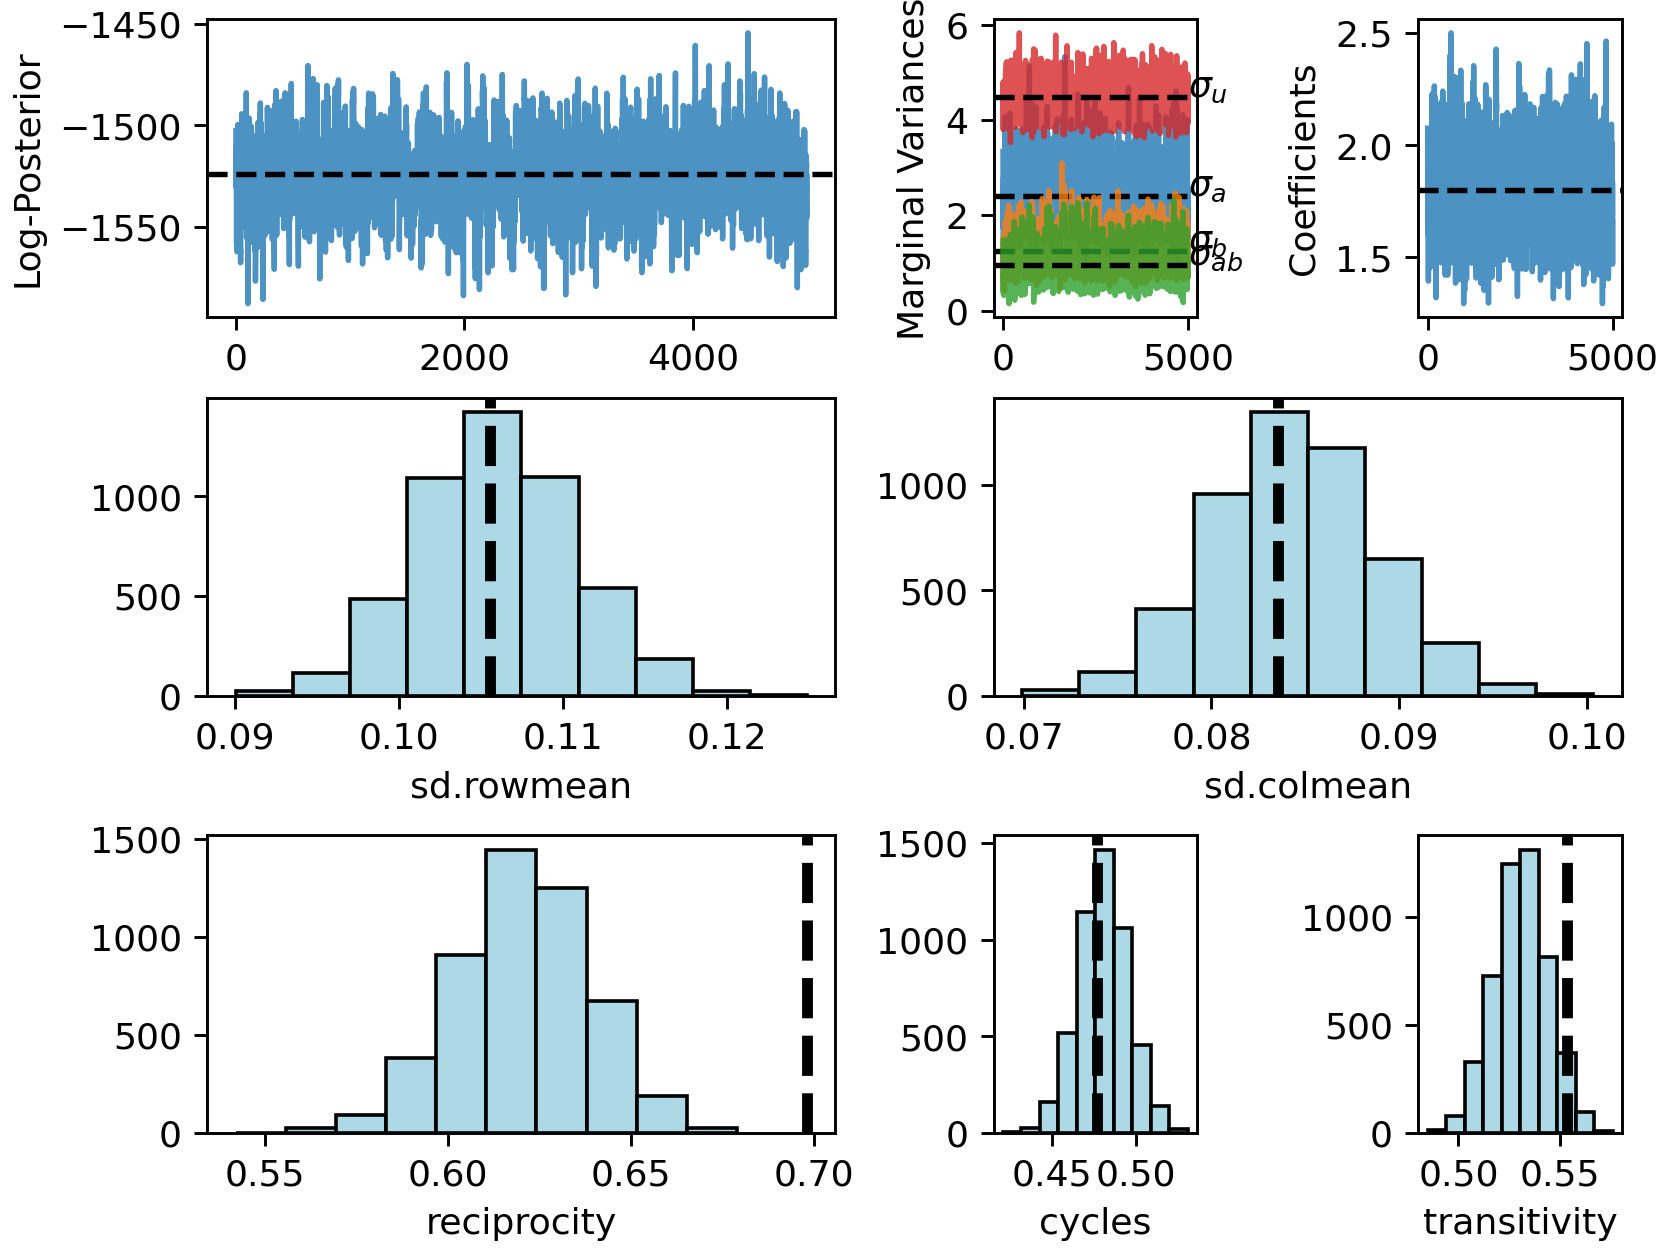

{'A': <Axes: label='A', ylabel='Log-Posterior'>,
 'B': <Axes: label='B', ylabel='Marginal Variances'>,
 'C': <Axes: label='C', ylabel='Coefficients'>,
 'D': <Axes: label='D', xlabel='sd.rowmean'>,
 'E': <Axes: label='E', xlabel='sd.colmean'>,
 'F': <Axes: label='F', xlabel='reciprocity'>,
 'G': <Axes: label='G', xlabel='cycles'>,
 'H': <Axes: label='H', xlabel='transitivity'>}

In [10]:
model_none.plot()